# Описание проект

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства.

Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

* Идея решения задачи от заказчика:

    * Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
    
    * Для модели выбрать тип виновника — только машина (car).
    
    * Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
    
    * Для моделирования ограничиться данными за 2012 год — они самые свежие.
    
    * Обязательное условие — учесть фактор возраста автомобиля.
    
* На основе модели исследовать основные факторы ДТП.
* Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
    * Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
    
    * Какие ещё факторы нужно учесть?
    
    * Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
    

## Подключитесь к базе. Загрузите таблицы sql

In [ ]:
!pip install optuna
!pip install category_encoders
# !pip install pandas
# !pip install matplotlib
# !pip install sqlalchemy
# !pip install seaborn
# !pip install warnings
# !pip install scikit-learn
# !pip install lightgbm
# !pip install collections
# !pip install re
# !pip install calendar
# !pip install numpy
# !pip install --upgrade scikit-learn


     |████████████████████████████████| 81 kB 1.7 MB/s eta 0:00:011


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import warnings # supress warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score,classification_report
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score,fbeta_score,f1_score,make_scorer
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from category_encoders import BinaryEncoder
import optuna
from lightgbm import LGBMClassifier
from collections import Counter
import re
import calendar
from math import ceil
import numpy as np

In [ ]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [ ]:
engine = create_engine(connection_string)

In [ ]:
# query = '''
# SELECT *
# FROM case_ids;
# '''

# sample_df = pd.read_sql_query(query, con=engine)

In [ ]:
## игнорируем будущие ошибки
warnings.filterwarnings('ignore')

# Исследование таблиц

In [ ]:
def run_query(query_):
    return pd.read_sql_query(query_, con=engine)



## Первичное исследование таблиц

### Информация о пострадавших машинах

In [ ]:
run_query("""SELECT *
FROM vehicles
LIMIT 10;""")


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


In [ ]:
run_query("""SELECT DISTINCT vehicle_age
FROM vehicles;""")


,vehicle_age
0,8.0
1,11.0
2,19.0
3,NaN
4,161.0
5,4.0
6,0.0
7,14.0
8,3.0
9,17.0


In [ ]:
run_query("""SELECT *
FROM case_ids
LIMIT 10;""")


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


case_id -
db_year

### Информация об участниках ДТП

In [ ]:
run_query("""SELECT *
FROM parties
LIMIT 10;""")


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


### Общая информация о ДТП

In [ ]:
run_query("""SELECT *
FROM collisions
LIMIT 10;""")


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


## Все ли таблицы имеют набор данных

Ответ:

Из запрсоов выше видно, что все таблица имеют набор данных

## Соответствует ли количество таблиц условию задачи

In [ ]:
run_query("""SELECT *
FROM case_ids
LIMIT 10;""")


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


Ответ:

В условии задачи не указана таблица case_ids, в которой есть следущие поля:

* case_id - PK таблицы это таблицы и FK для трех остальных таблиц.
* db_year - год базы

## Имеется ли общий ключ для связи таблиц.

In [ ]:
run_query('''SELECT DISTINCT party_count, COUNT(party_count)
FROM collisions
GROUP BY party_count
;''')


,party_count,count
0,1,274766
1,2,947251
2,3,140300
3,4,29389
4,5,6217
5,6,1446
6,7,386
7,8,140
8,9,47
9,10,30


In [ ]:
run_query("""SELECT *
FROM collisions
WHERE case_id LIKE '5196744'
""")


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,5196744,3711,san diego,0.0,None,1,clear,None,severe damage,27,vehicle code violation,improper turning,other,other object,dry,normal,dark with street lights,functioning,2011-02-12,01:32:00


In [ ]:
run_query("""SELECT *
FROM collisions
WHERE party_count = 27
;""")


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,5196744,3711,san diego,0.0,None,1,clear,None,severe damage,27,vehicle code violation,improper turning,other,other object,dry,normal,dark with street lights,functioning,2011-02-12,01:32:00


Ответ:

Для всех таблиц имеется PK для связи:

* **case_id - номер происшествия**

А также для того, чтобы иметь доступ ко всем машинам, учавствующим в дтп:
* **party_number - порядковый номер машины, которая участвовала в дтп**

# Статистический анализ факторов ДТП

## В какие месяцы происходит наибольшее количество аварий по годам?

In [ ]:

def num_to_month_name(row):
    return calendar.month_name[int(row)]

In [ ]:
run_query(f"""SELECT DISTINCT EXTRACT(YEAR FROM collision_date::date) AS month
FROM collisions


""")

,month
0,2010.0
1,2013.0
2,2020.0
3,2009.0
4,2011.0
5,2012.0


In [ ]:
years = [2009, 2010, 2011, 2012, 2013, 2020]

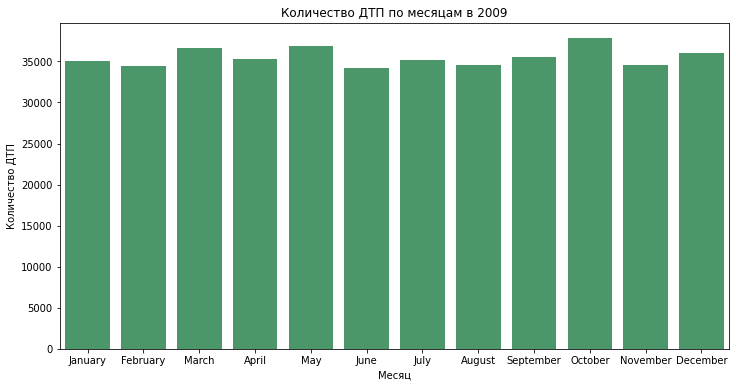

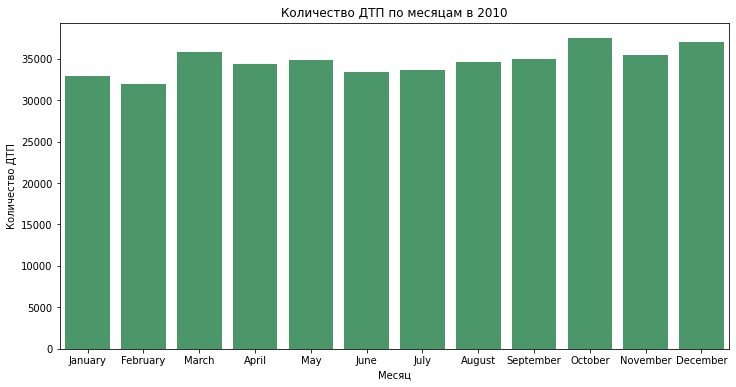

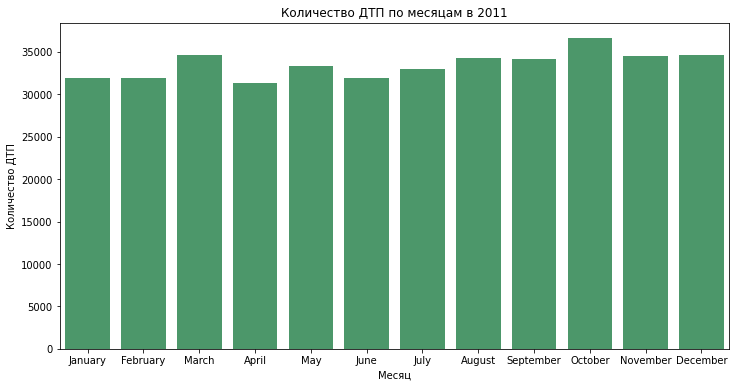

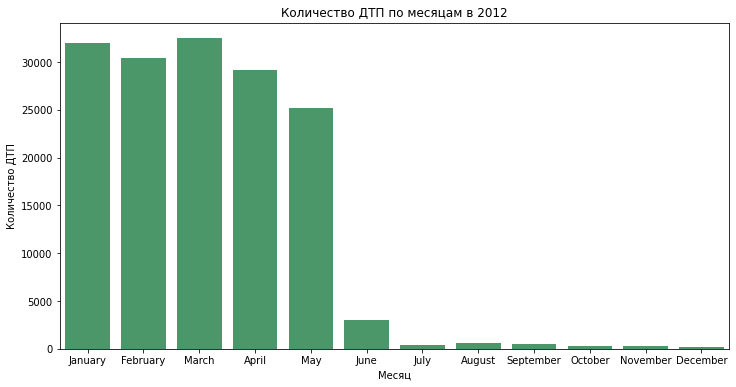

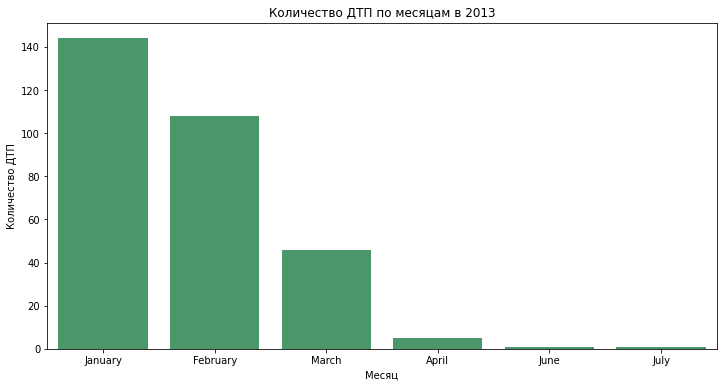

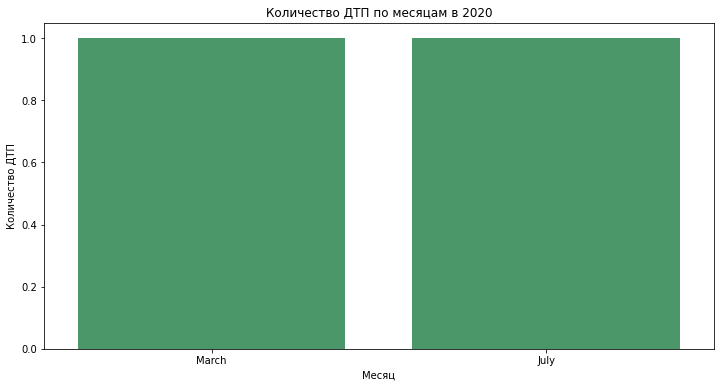

In [ ]:
for year in years:
    total_dtp_by_month =  run_query("""SELECT DISTINCT EXTRACT(MONTH FROM collision_date::date) AS month, COUNT(DISTINCT case_id) AS total_collisions
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date::date) = {}

GROUP BY EXTRACT(MONTH FROM collision_date::date)

""".format(year))
    total_dtp_by_month['month']= total_dtp_by_month['month'].apply(num_to_month_name)
    # Создание графика
    plt.figure(figsize=(12, 6))
    sns.barplot(x='month', y='total_collisions', data=total_dtp_by_month, color='#40a368')

    # Добавление заголовка и меток осей
    plt.title('Количество ДТП по месяцам в {}'.format(year))
    plt.xlabel('Месяц')
    plt.ylabel('Количество ДТП')

    # Отображение графика
    plt.show()

**Вывод:**
    
Исходя из графиков можно сделать выводы:

* В 2009 году наиболее аварийные месяцы это Октябрь, Май и Март
* В 2010 году - Октябрь, Март и Декабрь(близко май)
* В 2011 году - Октябрь, Март и третье место делят месяца с Августа по Декабрь
* Для 2012 и 2013 годов данных мало, однако тенденция на "мартовскую" аварийность сохраняется в 2012, а про 2013 год, тяжело сказать что либо, поскольку данных очень мало.
* Для 2020 только 2 записи, поэтому анализ здесь не уместен

In [ ]:
run_query("""SELECT DISTINCT db_year
FROM case_ids
""")

,db_year
0,2021


In [ ]:
run_query("""SELECT collision_date
FROM collisions
LIMIT 5
""")

,collision_date
0,2009-01-22
1,2009-01-03
2,2009-01-11
3,2009-01-11
4,2009-01-02


## Задачи для выполнения

In [ ]:
run_query("""SELECT *
FROM parties
LIMIT 5
""")

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


In [ ]:
run_query("""SELECT DISTINCT party_drug_physical
FROM parties
""")

,party_drug_physical
0,None
1,sleepy/fatigued
2,not applicable
3,impairment - physical
4,under drug influence
5,G


In [ ]:
run_query("""SELECT DISTINCT cellphone_in_use
FROM parties
""")

,cellphone_in_use
0,NaN
1,0.0
2,1.0


In [ ]:
run_query("""SELECT  DISTINCT vehicle_age
FROM vehicles
ORDER BY 1
""")

,vehicle_age
0,0.0
1,1.0
2,2.0
3,3.0
4,4.0
5,5.0
6,6.0
7,7.0
8,8.0
9,9.0


In [ ]:
run_query("""SELECT *
FROM vehicles
WHERE vehicle_age = 161
""")

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1275407,5403332,1,sedan,auto,161
1,1503403,5639033,2,sedan,manual,161
2,91813,4180401,3,hatchback,auto,161
3,768318,4898062,2,sedan,auto,161
4,208906,4302016,1,sedan,auto,161
5,1593,4015202,2,sedan,manual,161
6,768492,4898149,1,sedan,auto,161
7,209008,4302067,2,other,manual,161
8,860328,4990375,1,sedan,manual,161
9,1050942,5189844,3,other,manual,161


In [ ]:
run_query("""SELECT COUNT(*) AS vehicle_age_0
FROM vehicles
WHERE vehicle_age = 0
""")

,vehicle_age_0
0,40262


In [ ]:
run_query("""SELECT COUNT(*) AS vehicle_age_161
FROM vehicles
WHERE vehicle_age = 161
""")

,vehicle_age_161
0,17


Задачи для команды:

Для всех ДТП, где повреждение было **не царапина** и была **car** как виновник

1) Процент ДТП было совершенно с телефоном (cellphone_in_use=1) в руках от общего

2) Процент ДТП по каждому физическому недугу (party_drug_physical)

3) Процент ДТП по категории трезвости водителей

4) Процент ДТП по типам автомобилей

5) Процент ДТП по типам КПП

6) Процент ДТП по направлению

7) Процент ДТП по нарушениям

8) Процент ДТП по типу аварий

9) Процент ДТП по состоянию дороги

Дополнительные задания:
* Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
* Найдите самые частые причины ДТП (таблица parties).


-----

Для каждой задаче выполните следующие действия:

* Создайте sql-запрос;
* Постройте график;
* Сделайте вывод.


In [ ]:
run_query("""SELECT *
FROM parties
LIMIT 3
""")

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29,had not been drinking,None,0
1,23,3899454,2,road signs,0,7,had not been drinking,None,0
2,29,3899462,2,car,0,21,had not been drinking,None,0


In [ ]:
run_query("""SELECT *
FROM collisions
LIMIT 3
""")

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00


## Найдите самые частые причины ДТП (таблица parties).

In [ ]:
tmp = run_query("""SELECT primary_collision_factor, COUNT(*)
FROM collisions AS c JOIN parties AS p ON c.case_id = p.case_id
WHERE at_fault = 1
GROUP BY primary_collision_factor
ORDER BY 2 DESC
""")

In [ ]:
tmp

,primary_collision_factor,count
0,vehicle code violation,1281583
1,other improper driving,6497
2,fell asleep,47


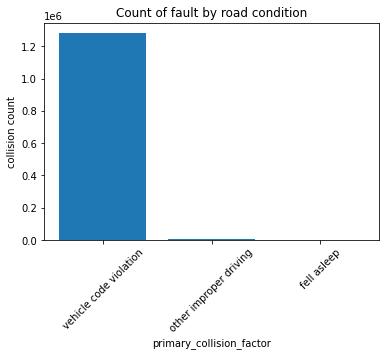

In [ ]:
# создание графика
fig, ax = plt.subplots()
ax.bar(tmp['primary_collision_factor'], tmp['count'], align='center')

# добавление заголовка и меток осей
ax.set_title('Count of fault by road condition')
ax.set_xticks(tmp['primary_collision_factor'])
ax.set_xticklabels(tmp['primary_collision_factor'], rotation=45)
ax.set_xlabel('primary_collision_factor')
ax.set_ylabel('collision count')

# отображение графика
plt.show()

Вывод:
    
Самая частая причина это нарушение ПДД - **1_281_583**

##  Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);


In [ ]:
tmp = run_query("""SELECT collisions.road_condition_1, AVG(parties.insurance_premium) AS avg_insurance_premium, COUNT(*) AS collision_count
FROM collisions
JOIN parties ON collisions.case_id = parties.case_id
WHERE collisions.road_condition_1 IS NOT NULL AND at_fault = 1
GROUP BY collisions.road_condition_1
ORDER BY 2 DESC;
""")

In [ ]:
tmp

,road_condition_1,avg_insurance_premium,collision_count
0,reduced width,39.680441,1357
1,obstruction,38.538947,4037
2,holes,38.184268,4628
3,construction,37.979980,17923
4,other,37.797822,4516
5,loose material,37.056024,2215
6,normal,36.965309,1243553
7,flooded,33.809926,1022


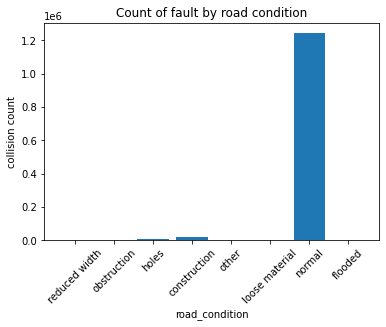

In [ ]:
# создание графика
fig, ax = plt.subplots()
ax.bar(tmp['road_condition_1'], tmp['collision_count'], align='center')

# добавление заголовка и меток осей
ax.set_title('Count of fault by road condition')
ax.set_xticks(tmp['road_condition_1'])
ax.set_xticklabels(tmp['road_condition_1'], rotation=45)
ax.set_xlabel('road_condition')
ax.set_ylabel('collision count')

# отображение графика
plt.show()

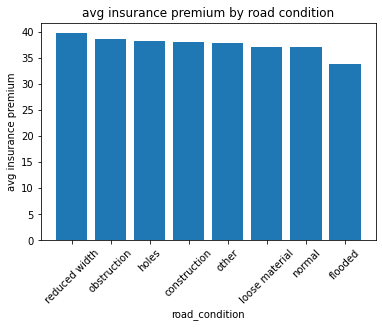

In [ ]:
# создание графика
fig, ax = plt.subplots()
ax.bar(tmp['road_condition_1'], tmp['avg_insurance_premium'], align='center')

# добавление заголовка и меток осей
ax.set_title('avg insurance premium by road condition')
ax.set_xticks(tmp['road_condition_1'])
ax.set_xticklabels(tmp['road_condition_1'], rotation=45)
ax.set_xlabel('road_condition')
ax.set_ylabel('avg insurance premium')

# отображение графика
plt.show()

Вывод:
    
Можем сделать вывод, что в основном премия относительно качества поверхности не сильно отличается, однако количество ДТП набиольшее на нормальной поверхности - 1_243_553. Наверно, стоит оставить данный признак

## Процент ДТП было совершенно с телефоном (cellphone_in_use=1) в руках от общего

In [ ]:
tmp = run_query("""SELECT cellphone_in_use AS cellphone_use, ROUND((COUNT(*) * 100.0)/(SELECT COUNT(*) FROM parties AS p JOIN collisions AS c ON c.case_id = p.case_id WHERE at_fault = 1 AND cellphone_in_use IS NOT NULL),1) AS percentage
FROM parties AS p JOIN collisions AS c ON c.case_id = p.case_id
WHERE at_fault = 1 AND cellphone_in_use IS NOT NULL
GROUP BY cellphone_in_use
""")

In [ ]:
tmp

,cellphone_use,percentage
0,0,97.7
1,1,2.3


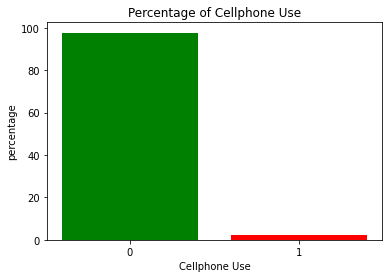

In [ ]:
# создание графика
fig, ax = plt.subplots()
ax.bar(tmp['cellphone_use'], tmp['percentage'], align='center', color=['green', 'red'])

# добавление заголовка и меток осей
ax.set_title('Percentage of Cellphone Use')
ax.set_xticks(tmp['cellphone_use'])
ax.set_xticklabels(tmp['cellphone_use'])
ax.set_xlabel('Cellphone Use')
ax.set_ylabel('percentage')

# отображение графика
plt.show()

**Вывод:**

Телефон был использован в 2.3% ДТП

## Процент ДТП по каждому физическому недугу (party_drug_physical)

In [ ]:
tmp = run_query("""SELECT party_drug_physical AS physical_condition,
ROUND((COUNT(*) * 100.0)/(
SELECT COUNT(*)  FROM parties AS p JOIN collisions AS c ON c.case_id = p.case_id WHERE at_fault = 1 AND
party_drug_physical IS NOT NULL AND
(party_drug_physical NOT IN  ('G','not applicable'))),1) AS percentage
FROM parties AS p JOIN collisions AS c ON c.case_id = p.case_id
WHERE (at_fault = 1) AND
(party_drug_physical IS NOT NULL) AND
(party_drug_physical NOT IN  ('G','not applicable'))
GROUP BY party_drug_physical
ORDER BY 2
""")

In [ ]:
tmp

,physical_condition,percentage
0,impairment - physical,7.2
1,sleepy/fatigued,46.2
2,under drug influence,46.6


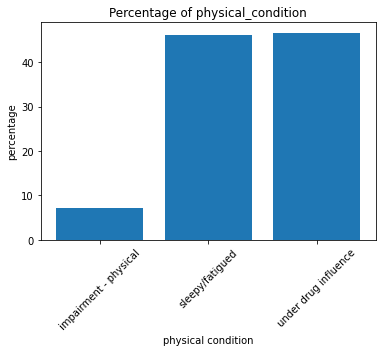

In [ ]:
# создание графика
fig, ax = plt.subplots()
ax.bar(tmp['physical_condition'], tmp['percentage'], align='center')

# добавление заголовка и меток осей
ax.set_title('Percentage of physical_condition')
ax.set_xticks(tmp['physical_condition'])
ax.set_xticklabels(tmp['physical_condition'], rotation=45)
ax.set_xlabel('physical condition')
ax.set_ylabel('percentage')

# отображение графика
plt.show()

**Вывод:**

Если человек имеет какое-либо ухудшение состояние, то процент ДТП повышается.

In [ ]:
tmp = run_query("""SELECT party_sobriety AS sobriety,
ROUND((COUNT(*) * 100.0)/(
SELECT COUNT(*)
FROM parties AS p JOIN collisions AS c
ON c.case_id = p.case_id
WHERE at_fault = 1 AND
party_sobriety IS NOT NULL AND
party_sobriety NOT LIKE  ('not applicable')),1) AS percentage
FROM parties AS p JOIN collisions AS c ON c.case_id = p.case_id
WHERE (at_fault = 1) AND
(party_sobriety IS NOT NULL) AND
(party_sobriety NOT LIKE  ('not applicable'))
GROUP BY party_sobriety
ORDER BY 2
""")

In [ ]:
tmp

,sobriety,percentage
0,"had been drinking, not under influence",1.0
1,"had been drinking, impairment unknown",1.4
2,"had been drinking, under influence",8.5
3,impairment unknown,14.7
4,had not been drinking,74.5


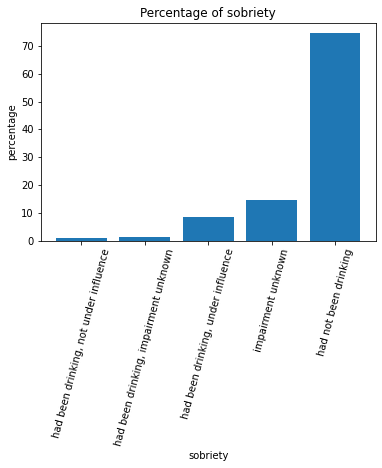

In [ ]:
# создание графика
fig, ax = plt.subplots()
ax.bar(tmp['sobriety'], tmp['percentage'], align='center')

# добавление заголовка и меток осей
ax.set_title('Percentage of sobriety')
ax.set_xticks(tmp['sobriety'])
ax.set_xticklabels(tmp['sobriety'], rotation=75)
ax.set_xlabel('sobriety')
ax.set_ylabel('percentage')

# отображение графика
plt.show()

**Вывод:**

Больше всего ДТП было не по вине алкоголя.

## Процент ДТП по типам автомобилей


In [ ]:
tmp = run_query("""SELECT vehicle_type AS vehicle_type,
ROUND((COUNT(*) * 100.0)/(
SELECT COUNT(*)
FROM parties AS p JOIN collisions AS c
ON c.case_id = p.case_id JOIN vehicles AS v
ON p.case_id = v.case_id
WHERE at_fault = 1 AND
vehicle_type IS NOT NULL),1) AS percentage
FROM parties AS p JOIN collisions AS c
ON c.case_id = p.case_id JOIN vehicles AS v
ON p.case_id = v.case_id
WHERE (at_fault = 1) AND
(vehicle_type IS NOT NULL)
GROUP BY vehicle_type
ORDER BY 2
""")

In [ ]:
tmp

,vehicle_type,percentage
0,other,0.1
1,minivan,4.0
2,hatchback,4.3
3,coupe,43.7
4,sedan,47.9


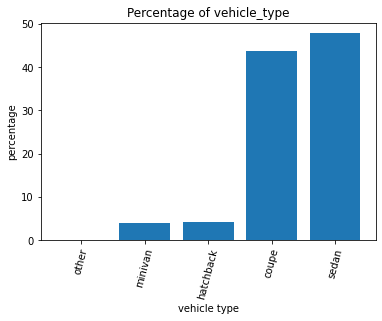

In [ ]:
# создание графика
fig, ax = plt.subplots()
ax.bar(tmp['vehicle_type'], tmp['percentage'], align='center')

# добавление заголовка и меток осей
ax.set_title('Percentage of vehicle_type')
ax.set_xticks(tmp['vehicle_type'])
ax.set_xticklabels(tmp['vehicle_type'], rotation=75)
ax.set_xlabel('vehicle type')
ax.set_ylabel('percentage')

# отображение графика
plt.show()

**Вывод:**

Купе и Седан явлюятся наиболее частыми виновниками ДТП

## Процент ДТП по типам КПП

In [ ]:
tmp = run_query("""SELECT vehicle_transmission AS vehicle_transmission,
ROUND((COUNT(*) * 100.0)/(
SELECT COUNT(*)
FROM parties AS p JOIN collisions AS c
ON c.case_id = p.case_id JOIN vehicles AS v
ON p.case_id = v.case_id
WHERE at_fault = 1 AND
vehicle_transmission IS NOT NULL),1) AS percentage
FROM parties AS p JOIN collisions AS c
ON c.case_id = p.case_id JOIN vehicles AS v
ON p.case_id = v.case_id
WHERE (at_fault = 1) AND
(vehicle_transmission IS NOT NULL)
GROUP BY vehicle_transmission
ORDER BY 2
""")

In [ ]:
tmp

,vehicle_transmission,percentage
0,manual,49.6
1,auto,50.4


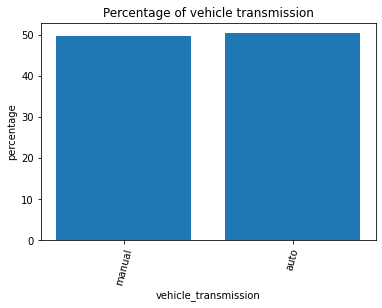

In [ ]:
# создание графика
fig, ax = plt.subplots()
ax.bar(tmp['vehicle_transmission'], tmp['percentage'], align='center')

# добавление заголовка и меток осей
ax.set_title('Percentage of vehicle transmission')
ax.set_xticks(tmp['vehicle_transmission'])
ax.set_xticklabels(tmp['vehicle_transmission'], rotation=75)
ax.set_xlabel('vehicle_transmission')
ax.set_ylabel('percentage')

# отображение графика
plt.show()

**Вывод:**

## Процент ДТП по направлению

In [ ]:
tmp = run_query("""SELECT direction AS direction,
ROUND((COUNT(*) * 100.0)/(
SELECT COUNT(*)
FROM parties AS p JOIN collisions AS c
ON c.case_id = p.case_id
WHERE at_fault = 1 AND
direction IS NOT NULL),1) AS percentage
FROM parties AS p JOIN collisions AS c
ON c.case_id = p.case_id
WHERE (at_fault = 1) AND
(direction IS NOT NULL)
GROUP BY direction
ORDER BY 2
""")

In [ ]:
tmp

,direction,percentage
0,west,22.6
1,east,22.7
2,north,27.2
3,south,27.4


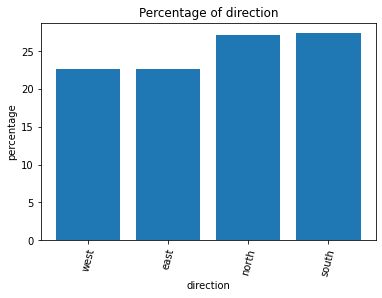

In [ ]:
# создание графика
fig, ax = plt.subplots()
ax.bar(tmp['direction'], tmp['percentage'], align='center')

# добавление заголовка и меток осей
ax.set_title('Percentage of direction')
ax.set_xticks(tmp['direction'])
ax.set_xticklabels(tmp['direction'], rotation=75)
ax.set_xlabel('direction')
ax.set_ylabel('percentage')

# отображение графика
plt.show()

**Вывод:**

На Южном и Северном направлении количество ДТП больше, чем на боковых сторонах света.

## Процент ДТП по нарушениям

In [ ]:
tmp = run_query("""SELECT pcf_violation_category AS pcf_violation_category,
ROUND((COUNT(*) * 100.0)/(
SELECT COUNT(*)
FROM parties AS p JOIN collisions AS c
ON c.case_id = p.case_id
WHERE at_fault = 1 AND
pcf_violation_category IS NOT NULL),1) AS percentage
FROM parties AS p JOIN collisions AS c
ON c.case_id = p.case_id
WHERE (at_fault = 1) AND
(pcf_violation_category IS NOT NULL)
GROUP BY pcf_violation_category
ORDER BY 2
""")

In [ ]:
tmp

,pcf_violation_category,percentage
0,lights,0.0
1,brakes,0.0
2,fell asleep,0.0
3,pedestrian dui,0.0
4,other equipment,0.1
5,hazardous parking,0.1
6,impeding traffic,0.1
7,unknown,0.2
8,other improper driving,0.5
9,improper passing,0.9


**Вывод:**

ТОП-5:

* speeding	34.1 %
* improper turning	18.4 %
* automobile right of way	12.2 %
* dui	8.6 %
* unsafe lane change	6.9 %






# Модель для оценки водительского риска

In [ ]:
run_query("""SELECT lighting,
SUM(at_fault), COUNT(at_fault)
FROM parties AS p JOIN collisions AS c
ON c.case_id = p.case_id JOIN vehicles AS v
ON p.case_id = v.case_id
WHERE collision_damage != '0' AND EXTRACT(YEAR FROM collision_date) = 2012 AND party_type LIKE 'car'
GROUP BY lighting
""")

,lighting,sum,count
0,dark with no street lights,7189,13709
1,dark with street lights,19523,40879
2,dark with street lights not functioning,227,484
3,daylight,71861,162829
4,dusk or dawn,3275,7163
5,None,298,714


In [ ]:
data = run_query("""SELECT p.case_id,
p.party_number,
vehicle_type,
vehicle_age,
weather_1,
road_surface,
road_condition_1,
direction,
lighting,
at_fault
FROM parties AS p JOIN collisions AS c
ON c.case_id = p.case_id JOIN vehicles AS v
ON p.case_id = v.case_id
WHERE collision_damage != 'scratch' AND
EXTRACT(YEAR FROM collision_date) = 2012 AND
party_type LIKE 'car' AND
vehicle_type IS NOT NULL  AND
vehicle_age IS NOT NULL AND
weather_1 IS NOT NULL AND
road_surface IS NOT NULL AND
road_condition_1 IS NOT NULL AND
road_condition_1 IS NOT NULL AND
direction IS NOT NULL AND
lighting IS NOT NULL
""")






Выбор признаков для модели:

В первую очередь нужно обозначить категории признаков, которые как-либо влияют на возмондость попадания в аварию:
1. Природные (состояние дороги или же обобщить - погода)
    * `weather_1` - во время осадков и после них в зависимости от температуры может образовываться лед, большое количество снега и лужи на дороге. Также во время осадков ухудшается видимость.
    * `road_surface` - от поверхности зависит скорость и резкость торможения, а также рулевой контроль
    * `direction` - от стороны света зависит погода, возможно стоит оставить только одно. Однако сторона навряд ли будет иметь сильную мультиколлениарность
    * `road_condition_1` - от качества дороги точно также зависит торможение, качество управление и ход машины.
    
    
2. Человеческий (здоровье физическое и моральное, в том числе и влияние веществ на оное) - Определить перед арендой автомобиля невозможно факторы, которые относятся к человека и его состоянию. Поэтому лучше всего взять только **природные** и **механические**.
    * `party_drug_physical` - если бы мы могли знать заранее состояние каждого водителя, то этот признак был бы важен, а так, к сожаленью, его взять не получится ввиду сложности определения. Такая же ситуация с признаками ниже. Их тоже не будем включать в модель
    * `cellphone_in_use`
    * `party_sobriety`
    
3. Механические (состояние транспорта, а также освещение дороги)
    * `lighting` - без должного освещения транспортные средства имеют ограниченный обзор. Поэтому без оного, шанс попасть в ДТП выше
    * `vehicle_type` - тип машины влияет на вес, маневренность, аэродинамику и т.п. вещи, поэтому это важный параметр при шансе столкновения и его последствия
    * `vehicle_age` - чем старше машина, тем выше шанс того, что могут отказать тормоза, электронная панель, КП и т.д.

<!-- p.party_number,
vehicle_type,
vehicle_age,
intersection,
weather_1,
road_surface,
road_condition_1,
lighting,
party_sobriety,
at_fault -->

In [ ]:
data.isna().mean()

case_id             0.0
party_number        0.0
vehicle_type        0.0
vehicle_age         0.0
weather_1           0.0
road_surface        0.0
road_condition_1    0.0
direction           0.0
lighting            0.0
at_fault            0.0
dtype: float64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86219 entries, 0 to 86218
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   case_id           86219 non-null  object
 1   party_number      86219 non-null  int64 
 2   vehicle_type      86219 non-null  object
 3   vehicle_age       86219 non-null  int64 
 4   weather_1         86219 non-null  object
 5   road_surface      86219 non-null  object
 6   road_condition_1  86219 non-null  object
 7   direction         86219 non-null  object
 8   lighting          86219 non-null  object
 9   at_fault          86219 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 6.6+ MB


In [ ]:
data.corr(method='spearman')

,party_number,vehicle_age,at_fault
party_number,1.000000,0.012852,-0.748159
vehicle_age,0.012852,1.000000,-0.012016
at_fault,-0.748159,-0.012016,1.000000


In [ ]:
# функция для подсчетов типов
def counter_of_type(data):
    return Counter(data.dtypes)


In [ ]:
# Функция для ознакомления с данными
def preview(data,n_row=4,
             head=True,
             info=True,
             columns=True,
             shape=True,
             isna=True,
             duplicated=True,
             dtypes_=True,
            describe_=True,
           clear_duples=True,
           lower_and_sep_col=True):
    global dct_nan
    global df_nan_columns
    dct_nan = {}
    if head:
        print(f'First {n_row} row(s) in the head of data')
        display(data.head(n_row))
        print('-'*30)
    if info:
        print('Data Information:')
        display(data.info())
        print('-'*30)
    if columns:
        print('Data columns:')
        display(data.columns)
        if lower_and_sep_col:
            COLUMN_REG = "(\w)([A-Z])"
            repl = r"\1_\2"
            data.columns = list(map(lambda x: re.sub(COLUMN_REG,repl,x).lower(),data.columns))
            print('Lowered and sepperated by words columns:')
            print(data.columns)
            print('-'*30)
    if shape:
        print('Data shape:')
        display(data.shape)
        print('-'*30)
    if isna:
        print('Data isna by row mean:')
        display(data.isna().mean())
        print()
        tmp = data.isna().mean()
        for i in range(len(tmp)):

            if tmp[i] > 0:
                dct_nan[tmp.index[i]] = tmp[i]
        if tmp.sum() > 0:
            df_nan_columns = pd.DataFrame.from_dict(dct_nan.items())
            df_nan_columns.columns = ['column','rate_of_nan']
            display(df_nan_columns)
        print('-'*30)
    if duplicated:
        print('Data clear duplicates sum:')
        duplets = data.duplicated().sum()
        display(duplets)
        if duplets >1 and clear_duples:
            data.drop_duplicates(inplace=True)
            print('Successful delete of {0} duplicates'.format(duplets))
        elif duplets == 1 and clear_duples:
            data.drop_duplicates(inplace=True)
            print('Successful delete of {0} duplicate'.format(duplets))
        print('-'*30)
    if dtypes_:
        print('Data dtypes:')
        display(data.dtypes)
        print('Number of each type:')
        print(counter_of_type(data))
        print('-'*30)
    if describe_:
        print('Major statistics for data:')
        display(data.describe())


In [ ]:
preview(data)

First 4 row(s) in the head of data


,case_id,party_number,vehicle_type,vehicle_age,weather_1,road_surface,road_condition_1,direction,lighting,at_fault
0,5403481,2,coupe,6,clear,dry,normal,south,dark with no street lights,0
1,5403312,1,coupe,13,clear,dry,normal,east,daylight,1
2,5403341,2,sedan,3,clear,dry,normal,north,daylight,0
3,5403341,2,coupe,5,clear,dry,normal,north,daylight,0


------------------------------
Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86219 entries, 0 to 86218
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   case_id           86219 non-null  object
 1   party_number      86219 non-null  int64 
 2   vehicle_type      86219 non-null  object
 3   vehicle_age       86219 non-null  int64 
 4   weather_1         86219 non-null  object
 5   road_surface      86219 non-null  object
 6   road_condition_1  86219 non-null  object
 7   direction         86219 non-null  object
 8   lighting          86219 non-null  object
 9   at_fault          86219 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 6.6+ MB


None

------------------------------
Data columns:


Index(['case_id', 'party_number', 'vehicle_type', 'vehicle_age', 'weather_1',
       'road_surface', 'road_condition_1', 'direction', 'lighting',
       'at_fault'],
      dtype='object')

Lowered and sepperated by words columns:
Index(['case_id', 'party_number', 'vehicle_type', 'vehicle_age', 'weather_1',
       'road_surface', 'road_condition_1', 'direction', 'lighting',
       'at_fault'],
      dtype='object')
------------------------------
Data shape:


(86219, 10)

------------------------------
Data isna by row mean:


case_id             0.0
party_number        0.0
vehicle_type        0.0
vehicle_age         0.0
weather_1           0.0
road_surface        0.0
road_condition_1    0.0
direction           0.0
lighting            0.0
at_fault            0.0
dtype: float64


------------------------------
Data clear duplicates sum:


2345

Successful delete of 2345 duplicates
------------------------------
Data dtypes:


case_id             object
party_number         int64
vehicle_type        object
vehicle_age          int64
weather_1           object
road_surface        object
road_condition_1    object
direction           object
lighting            object
at_fault             int64
dtype: object

Number of each type:
Counter({dtype('O'): 7, dtype('int64'): 3})
------------------------------
Major statistics for data:


,party_number,vehicle_age,at_fault
count,83874.000000,83874.000000,83874.000000
mean,1.655447,4.899754,0.477681
std,0.837320,3.190783,0.499505
min,1.000000,0.000000,0.000000
25%,1.000000,3.000000,0.000000
50%,1.000000,4.000000,0.000000
75%,2.000000,7.000000,1.000000
max,10.000000,161.000000,1.000000


In [ ]:
data[data['vehicle_age']==161]

,case_id,party_number,vehicle_type,vehicle_age,weather_1,road_surface,road_condition_1,direction,lighting,at_fault
34399,5542342,1,sedan,161,clear,dry,normal,north,daylight,1
34401,5542342,2,sedan,161,clear,dry,normal,north,daylight,0


In [ ]:
data.loc[data['vehicle_age']==161, 'vehicle_age'] = 16

In [ ]:
data[data['vehicle_age']==161]

,case_id,party_number,vehicle_type,vehicle_age,weather_1,road_surface,road_condition_1,direction,lighting,at_fault


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83874 entries, 0 to 86218
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   case_id           83874 non-null  object
 1   party_number      83874 non-null  int64 
 2   vehicle_type      83874 non-null  object
 3   vehicle_age       83874 non-null  int64 
 4   weather_1         83874 non-null  object
 5   road_surface      83874 non-null  object
 6   road_condition_1  83874 non-null  object
 7   direction         83874 non-null  object
 8   lighting          83874 non-null  object
 9   at_fault          83874 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 7.0+ MB


In [ ]:
data.select_dtypes(exclude='number').head()

,case_id,vehicle_type,weather_1,road_surface,road_condition_1,direction,lighting
0,5403481,coupe,clear,dry,normal,south,dark with no street lights
1,5403312,coupe,clear,dry,normal,east,daylight
2,5403341,sedan,clear,dry,normal,north,daylight
3,5403341,coupe,clear,dry,normal,north,daylight
4,5403344,coupe,clear,dry,normal,south,daylight


In [ ]:
data['case_id'] = data['case_id'].astype('int',errors='raise')

In [ ]:
def unique_by_col(df,*columns):
    tmp_lst = []
    for col in columns:
        df[col] = df[col].astype("category")
        nunique_counter = df[col].nunique()
        print(f'В столбце {col} находится {nunique_counter} уникальных значений')
        if col not in cat_int_columns:
            tmp_lst.append(nunique_counter)
    print(f'Медианное значение уникальных значений = {np.median(tmp_lst)}')

In [ ]:
cat_int_columns = ['intersection','at_fault']

In [ ]:
columns_to_drop = ['case_id','party_number']

In [ ]:
cat_columns = list(data.select_dtypes(exclude='number').columns)
numeric_columns = list((data.drop(columns=['case_id',
                  'party_number'],axis=1)
.select_dtypes(include='number')
.columns))

In [ ]:
cat_columns.extend(cat_int_columns)

In [ ]:
cat_columns

['vehicle_type',
 'weather_1',
 'road_surface',
 'road_condition_1',
 'direction',
 'lighting',
 'intersection',
 'at_fault']

In [ ]:
cat_columns= cat_columns[:-2]

In [ ]:
unique_by_col(data,*cat_columns)

В столбце vehicle_type находится 5 уникальных значений
В столбце weather_1 находится 7 уникальных значений
В столбце road_surface находится 4 уникальных значений
В столбце road_condition_1 находится 8 уникальных значений
В столбце direction находится 4 уникальных значений
В столбце lighting находится 5 уникальных значений
Медианное значение уникальных значений = 5.0


In [ ]:
columns_to_drop

['case_id', 'party_number']

In [ ]:
data_copy = data.copy().drop(columns_to_drop,axis=1)

In [ ]:
data_copy.head(2)

,vehicle_type,vehicle_age,weather_1,road_surface,road_condition_1,direction,lighting,at_fault
0,coupe,6,clear,dry,normal,south,dark with no street lights,0
1,coupe,13,clear,dry,normal,east,daylight,1


In [ ]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83874 entries, 0 to 86218
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   vehicle_type      83874 non-null  category
 1   vehicle_age       83874 non-null  int64   
 2   weather_1         83874 non-null  category
 3   road_surface      83874 non-null  category
 4   road_condition_1  83874 non-null  category
 5   direction         83874 non-null  category
 6   lighting          83874 non-null  category
 7   at_fault          83874 non-null  int64   
dtypes: category(6), int64(2)
memory usage: 2.4 MB


In [ ]:
num_cols = ['vehicle_age']

In [ ]:
num_cols

['vehicle_age']

In [ ]:
rs=7

In [ ]:
features_ln = data_copy.drop('at_fault',axis=1)
target_ln = data_copy['at_fault']

In [ ]:
features_train_ln, features_test_ln, target_train, target_test = train_test_split(features_ln,
                                                                                        target_ln,
                                                                                        shuffle=True,
                                                                                        test_size=0.3,
                                                                                        random_state=rs,
                                                                                       stratify=target_ln)


In [ ]:
cat_columns

['vehicle_type',
 'weather_1',
 'road_surface',
 'road_condition_1',
 'direction',
 'lighting']

In [ ]:
num_cols

['vehicle_age']

In [ ]:
num_cols

['vehicle_age']

In [ ]:
features_train_ln.columns

Index(['vehicle_type', 'vehicle_age', 'weather_1', 'road_surface',
       'road_condition_1', 'direction', 'lighting'],
      dtype='object')

In [ ]:
cat_columns

['vehicle_type',
 'weather_1',
 'road_surface',
 'road_condition_1',
 'direction',
 'lighting']

In [ ]:
features_ln[features_ln['lighting']=='none']

,vehicle_type,vehicle_age,weather_1,road_surface,road_condition_1,direction,lighting


In [ ]:
# для сохранения колонок  remainder='passthrough'
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='error'),
        cat_columns
    ),
    remainder='passthrough'
)


# применяем трансформер и создаем датафрейм
X_transformed = col_transformer.fit_transform(features_train_ln)
columns = col_transformer.named_transformers_['onehotencoder'].get_feature_names(cat_columns).tolist() + num_cols
features_train_new = pd.DataFrame(col_transformer.transform(features_train_ln).toarray(), columns=columns, index=features_train_ln.index)
X_transformed = col_transformer.transform(features_test_ln)
columns = col_transformer.named_transformers_['onehotencoder'].get_feature_names(cat_columns).tolist() + num_cols
features_test_new = pd.DataFrame(col_transformer.transform(features_test_ln).toarray(), columns=columns, index=features_test_ln.index)


In [ ]:
features_test_new

,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,...,road_condition_1_other,road_condition_1_reduced width,direction_north,direction_south,direction_west,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,vehicle_age
70614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0
18283,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
78071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
14756,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
12672,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
59765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
39061,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0
72065,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12.0


In [ ]:
data['at_fault'].value_counts()

0    43809
1    40065
Name: at_fault, dtype: int64

**Вывод:**

Небольшой дизбаланс. Лучше использовать Fbeta_score. Так как заказчик не уточнил, что ему важно - точность или полнота, beta = 1- гармоническое среднее между точностью и полнотой.

## Бустинг и Случайный лес

In [ ]:

def objective(trial):
    clf_name = trial.suggest_categorical('classifier',['Forest','CatBoost'])
    if clf_name == 'CatBoost':
        iterations= trial.suggest_int('iterations', 50, 200,10)
        clf_obj =CatBoostClassifier(depth=16,
                                   iterations=iterations,
                                    random_state=rs)

    if clf_name == 'Forest':
        n_estimators = trial.suggest_int('n_estimators', 20, 250,10)
        max_depth = trial.suggest_int('max_depth', 5, 40,5)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,
                                         max_depth=max_depth,
                                         n_estimators=n_estimators,
                                         random_state=rs)

    # Определяем метрику, на основе которой будет производиться оценка качества
    scorer = make_scorer(f1_score)
    clf_obj.fit(features_train_new,target_train)
    # Выполняем кросс-валидацию
    scores = cross_val_score(clf_obj, features_train_new, target_train, cv=3, scoring=scorer)
    # Вычисляем среднее значение F-меры по всем фолдам
    mean_score = scores.mean()
    return mean_score


In [ ]:
np.random.seed(7)
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials =50)
    print(study.best_trial)


[I 2023-04-21 18:32:16,728] A new study created in memory with name: no-name-61ee7ce1-b975-4a4c-b9c8-5f5c7ca5bd4b


Learning rate set to 0.282548
0:	learn: 0.6883026	total: 101ms	remaining: 18.2s
1:	learn: 0.6858932	total: 116ms	remaining: 10.4s
2:	learn: 0.6822369	total: 1.28s	remaining: 1m 15s
3:	learn: 0.6796793	total: 2.74s	remaining: 2m
4:	learn: 0.6791738	total: 2.77s	remaining: 1m 36s
5:	learn: 0.6780943	total: 3.67s	remaining: 1m 46s
6:	learn: 0.6768602	total: 4.53s	remaining: 1m 52s
7:	learn: 0.6750627	total: 5.08s	remaining: 1m 49s
8:	learn: 0.6750307	total: 5.09s	remaining: 1m 36s
9:	learn: 0.6750138	total: 5.1s	remaining: 1m 26s
10:	learn: 0.6742117	total: 5.99s	remaining: 1m 32s
11:	learn: 0.6741615	total: 6.01s	remaining: 1m 24s
12:	learn: 0.6741471	total: 6.02s	remaining: 1m 17s
13:	learn: 0.6733343	total: 6.94s	remaining: 1m 22s
14:	learn: 0.6732439	total: 6.97s	remaining: 1m 16s
15:	learn: 0.6727322	total: 7.87s	remaining: 1m 20s
16:	learn: 0.6726785	total: 7.89s	remaining: 1m 15s
17:	learn: 0.6723448	total: 7.97s	remaining: 1m 11s
18:	learn: 0.6716488	total: 8.85s	remaining: 1m 15s

[W 2023-04-21 18:36:34,313] Trial 0 failed with parameters: {'classifier': 'CatBoost', 'iterations': 180} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_195/285611897.py", line 22, in objective
    scores = cross_val_score(clf_obj, features_train_new, target_train, cv=3, scoring=scorer)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 266, in cross_validate
    results = parallel(
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_

KeyboardInterrupt: 

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.4043511900463704], datetime_start=datetime.datetime(2023, 4, 20, 12, 49, 5, 253723), datetime_complete=datetime.datetime(2023, 4, 20, 12, 49, 22, 24194), params={'classifier': 'Forest', 'n_estimators': 250, 'max_depth': 10, 'criterion': 'gini'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('Forest',)), 'n_estimators': IntDistribution(high=250, log=False, low=20, step=10), 'max_depth': IntDistribution(high=40, log=False, low=5, step=5), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=0, value=None)


In [ ]:


# определение параметров для подбора
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}

# создание экземпляра логистической регрессии
lr = LogisticRegression()

# создание экземпляра GridSearchCV и запуск поиска по сетке
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(features_train_new, target_train)

# вывод лучших параметров и метрик на обучающей и тестовой выборке
print('Лучшие параметры:', grid_search.best_params_)
print('F1-score на обучающей выборке:', grid_search.best_score_)
print('F1-score на тестовой выборке:', grid_search.score(features_test_new, target_test))


## Оценка лучшей модели для оценки водительского риска

In [ ]:


### для тестовой и валидационной выборках лучшей модели
def metrics_check(target_valid,predict_valid):
    print(f'Accuracy для валидационной выборки: {accuracy_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'Balanced accuracy для валидационной выборки: {balanced_accuracy_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'F1-score для валидационной выборки: {f1_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'Precision score для валидационной выборки: {precision_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'Recall score для валидационной выборки: {recall_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'F-beta score для валидационной выборки: {fbeta_score(target_valid,predict_valid,beta=1)}')
    print('-'*100)

def valuate(model_,features_train_,features_test_,target_train_,target_test_):

    model_.fit(features_train_,target_train_)
    predicted = model_.predict(features_test_)



    print('-'*30)
    print('Метрики')
    metrics_check(target_test_,predicted)

    print('-'*30)
    print('Отчет по классификации')
    print(classification_report(target_test_,predicted))

In [ ]:
lr = LogisticRegression(C=1,penalty='l1',solver='liblinear')

In [ ]:
lr.fit(features_train_new,target_train)

In [ ]:
prediction = lr.predict(features_test_new)

In [ ]:
f1_score(target_test,prediction)

In [ ]:
model = RandomForestClassifier(criterion="gini",
                                         max_depth=10,
                                         n_estimators=250,
                                         random_state=rs)

In [ ]:
model.fit(features_train_new,target_train)

In [ ]:
prediction = model.predict(features_test_new)

In [ ]:
f1_score(target_test,prediction)

In [ ]:
valuate(model,features_train_new,features_test_new,target_train,target_test)

In [ ]:
valuate(lr,features_train_new,features_test_new,target_train,target_test)

In [ ]:
valuate(model_=model,features_train_=features_train_new,features_test_=features_test_new,target_train_=target_train,target_test_=target_test)

Вывод:

Классификация невиновных среднего качества в точности, но в полноте очень даже хорошие показатели. Для увеличение метрик качества классификации можно попробовать UpSempling 1 класса и посмотреть на результат.

## Проведите анализ важности факторов ДТП

In [ ]:
# получение важностей признаков
importances = model.feature_importances_

# отсортированные важности признаков
sorted_idx = importances.argsort()[::-1]

# вывод важности признаков
for i in sorted_idx:
    print(f"{features_test_new.columns[i]}: {importances[i]}")

# построение графика важности признаков
plt.bar(range(features_test_new.shape[1]), importances[sorted_idx])
plt.xticks(range(features_test_new.shape[1]), features_test_new.columns[sorted_idx], rotation=90)
plt.show()

Проанализируем один из самых важных признаков - vehicle_age, и выдадим портрет а/м, который с наибольшей вроятностью может попасть а ДТП.

In [ ]:
data.groupby(['vehicle_age']).agg(func={'at_fault':['sum','count']})

In [ ]:
data[['vehicle_age', 'at_fault']].corr(method='spearman')

In [ ]:

# Определение факторов и целевой переменной
X = data[['vehicle_age']]
y = data['at_fault']

# Создание модели линейной регрессии
model = LinearRegression()
model.fit(X, y)

print('Пересечение:', model.intercept_)

# Предсказание значений целевой переменной для новых данных
new_data = pd.DataFrame({'vehicle_age': [i for i in range(1,16,2)]})
predicted_y = model.predict(new_data)
print('Предсказанные значения at_fault:', predicted_y)

Вывод:

Маленькый, отрицательный коэффициент корреляции Спирмана говорит нам о том, что чем старше машина, тем меньше вероятность попадания в ДТП. То есть, основываясь лишь на факторе возраста а/м, то складывается впечатление, что если а/м новый, то вероятность попасть в ДТП выше, чем иначе.


## Выводы

* Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?

Ответ:
    Возможно, но при наличии качественных данных и всеобъемлющих признаков

* Какие ещё факторы нужно учесть?
    
Ответ:

Обязательно нужно учитывать физическое и моральное состояние человека:
* weather_1

* road_surface

* direction

* road_condition_1

* party_drug_physical

* cellphone_in_use

* party_sobriety

* lighting

* vehicle_type

* vehicle_age
        

* Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

Ответ:

  Для увеличения качества модели обязательно нужно оборудовать а/м датчиками и камерами, которые буду собирать данные о погоде и состоянии машины, а также будет оценивать настроение водителя по мимики лица

Показатели лучшей модели:

* Логистическая регрессия:
    * f1-0 - 0.61
    * f1-1 - 46

где f1-0 - предсказания невиновных, а f1-1 наоборот


Если иметь доступ к данных состояние человека перед арендой автомобиля, то можно увеличить в принципе до 60-70% успешных предсказаний.